# WISE Catalog Database Generator
Generates a database, CSV file, and DataFrame pickle containing all relevant information about Galactic HII regions in the
[WISE Catalog of Galactic HII Regions](http://astro.phys.wvu.edu/wise/)
([paper](https://ui.adsabs.harvard.edu/abs/2014ApJS..212....1A/abstract)).

First, download the data files from THIS LINK.

Copyright(C) 2025 by<br>
Trey V. Wenger; tvwenger@gmail.com<br>
L. D. Anderson; <br>
This code is licensed under MIT license (see LICENSE for details)

In [1]:
# Import packages
import os
import pandas as pd
import sqlite3
import pickle
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
import glob

from hii_db import utils


pd.set_option('display.max_columns', None) # Show all columns
pd.set_option('display.max_rows', None) # Show all columns
pd.set_option('display.width', 1000) # Avoid line wrapping

In [2]:
# Set filepath for data directory
data_dir = "/media/drive1/hii-db-data/"

# WISE Catalog master CSV file
wise_master_version = 3.0
wise_master = os.path.join(data_dir, f"wise/wise_hii_master_V{wise_master_version}.csv")

if not os.path.exists(wise_master):
    raise FileNotFoundError(wise_master)
print(f"Using WISE Catalog master file: {wise_master}")

Using WISE Catalog master file: /media/drive1/hii-db-data/wise/wise_hii_master_V3.0.csv


# Build Dataframe
The dataframe is built on top of the WISE Catalog master CSV file.

In [3]:
# Read the CSV file into a pandas DataFrame
WISE_df = pd.read_csv(wise_master)

# Get rid of NaNs at the end of the file
WISE_df = WISE_df.dropna(axis=1, how='all')

# Fix groups
WISE_df.loc[(WISE_df['Catalog'] == 'known') & (WISE_df['Group_Flag'] == 1), 'Catalog'] = 'group'

# Make GName
WISE_df['GName'] = utils.generate_gname(WISE_df['GLong'], WISE_df['GLat'])

# Make RA and Dec
galactic_coord = SkyCoord(l=WISE_df['GLong'], b=WISE_df['GLat'], frame='galactic', unit=(u.deg, u.deg))
icrs_coord = galactic_coord.transform_to('icrs')
WISE_df['RA (J2000)'] = icrs_coord.ra.value
WISE_df['Dec (J2000)'] = icrs_coord.dec.value

# Split the 'Name' column in WISE_df by semicolons to handle multiple names
WISE_df['Name_Split'] = WISE_df['Name'].apply(lambda x: x.split(';') if isinstance(x, str) else [])

print(f"Loaded {len(WISE_df)} entries from the WISE Catalog master CSV file.")

Loaded 8589 entries from the WISE Catalog master CSV file.


# Load Radio Recombination Line Data

In [4]:
# RRL_Surveys df
pkl_directory = os.path.join(data_dir, 'rrl_surveys')

# List of columns to keep
rrl_columns = [
    'Name', 'GName', 'GLong', 'GLat', 'RA (J2000)', 'Dec (J2000)', 'TL', 'e_TL', 'FWHM', 'e_FWHM', 
    'VLSR', 'e_VLSR', 'VLSR_He', 'e_VLSR_He', 'FWHM_He', 'e_FWHM_He', 
    'TL_He', 'e_TL_He', 'VLSR_C', 'e_VLSR_C', 'FWHM_C', 'e_FWHM_C', 'TL_C', 'e_TL_C', 
    'Telescope', 'Resolution', 'Wavelength', 'Frequency', 
    'Author', 'Year',
]
rrl_dtypes = {
    key: float
    for key in rrl_columns
}
rrl_dtypes["Name"] = str
rrl_dtypes["GName"] = str
rrl_dtypes["Telescope"] = str
rrl_dtypes["Author"] = str
rrl_dtypes["Year"] = int    

# Load each .pkl file into the dataframe
RRL_Surveys_df_original = pd.DataFrame()
for filename in os.listdir(pkl_directory):
    if filename.endswith('.pkl') and not filename.endswith('_2.pkl'):
        file_path = os.path.join(pkl_directory, filename)
        
        # Load the .pkl file into a pandas DataFrame
        df = pd.read_pickle(file_path)
        df_filtered = df[rrl_columns].astype(rrl_dtypes)
        print(f"Loaded {filename}")
        # Remove rows where 'VLSR', 'FWHM', or 'TL' are NaN, None, or 0
        #df_filtered = df_filtered[~df_filtered[['VLSR', 'FWHM', 'TL']].isin([None, 0]).any(axis=1) & 
        #                          df_filtered[['VLSR', 'FWHM', 'TL']].notna().all(axis=1)]


        # Remove any columns with all NaN or empty entries before concatenation
        #df_filtered = df_filtered.dropna(axis=1, how='all')  # Drop columns where all values are NaN
        RRL_Surveys_df_original = pd.concat([RRL_Surveys_df_original, df_filtered], ignore_index=True)

print(f"Loaded {len(RRL_Surveys_df_original)} RRL detections.")

Loaded quireza.pkl
Loaded hrds_diffuse.pkl
Loaded balser.pkl
Loaded shrds_pilot.pkl
Loaded fich.pkl
Loaded araya.pkl
Loaded glostar_rrls.pkl
Loaded gdigs.pkl
Loaded balser15.pkl
Loaded hrds_wise.pkl
Loaded lockman89.pkl
Loaded watson.pkl
Loaded sewilo.pkl
Loaded shrds.pkl
Loaded lockman96.pkl
Loaded arecibo_hrds.pkl
Loaded fast_rrls.pkl
Loaded hrds.pkl
Loaded caswell87.pkl
Loaded 3788 RRL detections.


In [5]:
######################## Deal with multiple RRLs from individual observations##########################################
# Sort the DataFrame by 'GLong' and 'GLat' to ensure duplicates are adjacent
RRL_Surveys_df = RRL_Surveys_df_original.sort_values(by=['GLong', 'GLat', 'TL'], ascending = [True, True, False])
print(f"Starting RRL detection count: {len(RRL_Surveys_df)}")

# For lines with multiple components, store additional line parameters in new variables
RRL_Surveys_df['VLSR2'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['VLSR'].shift(-1)
RRL_Surveys_df['e_VLSR2'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_VLSR'].shift(-1)
RRL_Surveys_df['FWHM2'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['FWHM'].shift(-1)
RRL_Surveys_df['e_FWHM2'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_FWHM'].shift(-1)
RRL_Surveys_df['TL2'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['TL'].shift(-1)
RRL_Surveys_df['e_TL2'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_TL'].shift(-1)
RRL_Surveys_df['VLSR3'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['VLSR'].shift(-2)
RRL_Surveys_df['e_VLSR3'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_VLSR'].shift(-2)
RRL_Surveys_df['FWHM3'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['FWHM'].shift(-2)
RRL_Surveys_df['e_FWHM3'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_FWHM'].shift(-2)
RRL_Surveys_df['TL3'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['TL'].shift(-2)
RRL_Surveys_df['e_TL3'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_TL'].shift(-2)
RRL_Surveys_df['VLSR4'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['VLSR'].shift(-3)
RRL_Surveys_df['e_VLSR4'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_VLSR'].shift(-3)
RRL_Surveys_df['FWHM4'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['FWHM'].shift(-3)
RRL_Surveys_df['e_FWHM4'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_FWHM'].shift(-3)
RRL_Surveys_df['TL4'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['TL'].shift(-3)
RRL_Surveys_df['e_TL4'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_TL'].shift(-3)

####################### Remove duplicate entries that arise in the cases of multiple lines###############################
# First, get the duplicate rows based on 'GLong' and 'GLat'
duplicates = RRL_Surveys_df.duplicated(subset=['GLong', 'GLat'], keep='first')
print(f"Duplicate RRL detections based on position: {duplicates.sum()}")

# For rows with matching 'GLong' and 'GLat', store the shortest name
RRL_Surveys_df['Name'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['Name'].transform(lambda x: x.loc[x.str.len().idxmin()])

# Remove the duplicate rows (keep the first occurrence)
RRL_Surveys_df = RRL_Surveys_df[~duplicates]
print(f"RRL detections remain after dropping duplicates: {len(RRL_Surveys_df)}")

# Reset the index after dropping rows
RRL_Surveys_df = RRL_Surveys_df.reset_index(drop=True)

####### Now deal with the rare instances of when the same source was observed twice, with the same name, in different surveys#######
# Sort the dataframe by 'Year' and 'GLong'
RRL_Surveys_df_sorted = RRL_Surveys_df.sort_values(by=['Year', 'GName'], ascending=[False, True])

# Drop duplicates, keeping the first (highest 'Year') for each 'Name'
RRL_Surveys_df_unique = RRL_Surveys_df_sorted.drop_duplicates(subset='GName', keep='first')

# Sort back into correct order
RRL_Surveys_df = RRL_Surveys_df_unique.sort_values(by=['GLong', 'GLat'])

# Find the rows that were dropped (those in sorted but not in unique)
dropped_rows = RRL_Surveys_df_sorted.loc[~RRL_Surveys_df_sorted.index.isin(RRL_Surveys_df.index)]
print(f"RRL detections in multiple surveys: {len(dropped_rows)}")
print(f"RRL detections remain after dropping multi-survey detections: {len(RRL_Surveys_df)}")

# Find the rows that took their place
dropped_names = dropped_rows['GName']

# Get the rows that were kept and have the same names as the dropped ones
replacement_rows = RRL_Surveys_df[RRL_Surveys_df['GName'].isin(dropped_names)]

# Show the dropped rows
print("Rows that were dropped and their replacements:")
for name in dropped_names:
    dropped_row = dropped_rows[dropped_rows['GName'] == name].iloc[0]
    replacement_row = replacement_rows[replacement_rows['GName'] == name].iloc[0]
    
    print(f"Name: {name}")
    print(f"  Dropped - VLSR: {dropped_row['VLSR']}, Author: {dropped_row['Author']}")
    print(f"  Kept    - VLSR: {replacement_row['VLSR']}, Author: {replacement_row['Author']}")
    print("--------------------------------------------------")

Starting RRL detection count: 3788
Duplicate RRL detections based on position: 531
RRL detections remain after dropping duplicates: 3257
RRL detections in multiple surveys: 16
RRL detections remain after dropping multi-survey detections: 3241
Rows that were dropped and their replacements:
Name: G326.472-00.377
  Dropped - VLSR: -53.4, Author: Wenger et al. (2021)
  Kept    - VLSR: -53.7, Author: Wenger et al. (2021)
--------------------------------------------------
Name: G338.631+00.142
  Dropped - VLSR: -37.0, Author: Wenger et al. (2021)
  Kept    - VLSR: 1.5, Author: Wenger et al. (2021)
--------------------------------------------------
Name: G313.671-00.104
  Dropped - VLSR: -54.6, Author: Brown et al. (2017)
  Kept    - VLSR: -53.8, Author: Wenger et al. (2021)
--------------------------------------------------
Name: G011.110-00.399
  Dropped - VLSR: 2.1, Author: Sewilo et al. (2004)
  Kept    - VLSR: -1.69, Author: Khan et al. (2024)
--------------------------------------------

In [6]:
from hii_db.utils import add_region

################# Other fixes######################################
# Filter rows where the 'TL' column is NaN
nan_TL_rows = RRL_Surveys_df[RRL_Surveys_df['TL'].isna()]

# Print the 'Author' column for those rows
print('These have missing line parameters')
print(nan_TL_rows['Author'])

# Remove blank spaces
RRL_Surveys_df['Name'] = RRL_Surveys_df['Name'].str.replace(' ', '', regex=False)

#################### Add other regions that aren't in main surveys################################
# Update for 'G000.394-00.540'
add_region(RRL_Surveys_df,  
            VLSR=24.0, FWHM=39.0, Telescope='Effelsberg', Resolution=2.5, 
            Wavelength=6, Frequency=5, Lines='H110', 
            GLong=0.394, GLat=-0.540, 
            Name='G000.394-00.540', Author='Downes et al. (1980)')

# Update for 'G000.489-00.668'
add_region(RRL_Surveys_df, 
            VLSR=17.5, FWHM=24.0, Telescope='Effelsberg', Resolution=2.5, 
            Wavelength=6, Frequency=5, Lines='H110', 
            GLong=0.510, GLat=-0.051, Name='G000.510-00.051', Author='Downes et al. (1980)')

# Update for 'G000.572-00.628'
add_region(RRL_Surveys_df, 
            VLSR=20.0, FWHM=15.0, Telescope='Effelsberg', Resolution=2.5, 
            Wavelength=6, Frequency=5, Lines='H110', 
            GLong=0.572, GLat=-0.628, Name='G000.572-00.628', Author='Downes et al. (1980)')

# Update for 'G001.149-00.062'
add_region(RRL_Surveys_df, 
            VLSR=-17.0, FWHM=20.0, Telescope='Effelsberg', Resolution=2.5, 
            Wavelength=6, Frequency=5, Lines='H110', 
            GLong=1.149, GLat=-0.062, Name='G001.149-00.062', Author='Downes et al. (1980)')

# Update for 'G000.361-00.780;S20'
add_region(RRL_Surveys_df, 
            VLSR=20.0, FWHM=23.0, Telescope='Effelsberg', Resolution=2.5, 
            Wavelength=6, Frequency=5, Lines='H110', 
            GLong=0.361, GLat=-0.780, Name='G00.361-00.780;S20', Author='Downes et al. (1980)')

# Update for 'G359.277-00.264'
add_region(RRL_Surveys_df,
            VLSR=-2.4, e_VLSR=0.6, FWHM=20.1, e_FWHM=1.5, Telescope='Effelsberg', 
            Resolution=0.8, Wavelength=2, Frequency=15, Lines='H76', 
            GLong=359.277, GLat=-0.264, Name='G359.277-00.264', Author='Wink, Altenhoff, & Metzger (1982)')

# Update for 'G268.034-00.984'
add_region(RRL_Surveys_df,
            VLSR=1.8, e_VLSR=0.9, FWHM=36.5, e_FWHM=1.2, Telescope='Parkes', 
            Resolution=4.4, Wavelength=6, Frequency=5, Lines='H109', 
            GLong=268.034, GLat=-0.984, Name='G268.034-00.984', Author='Wilson et al. (1970)')

# Update for 'G287.782-00.819'
add_region(RRL_Surveys_df,
            VLSR=-21.3, e_VLSR=0.8, FWHM=38.8, e_FWHM=6.0, Telescope='Parkes', 
            Resolution=4.4, Wavelength=6, Frequency=5, Lines='H109', 
            GLong=287.782, GLat=-0.819, Name='G287.782-00.819', Author='Wilson et al. (1970)')

# Update for 'G333.605-00.095'
add_region(RRL_Surveys_df,
            VLSR=-53.7, e_VLSR=3.1, FWHM=44.7, e_FWHM=6.0, Telescope='Parkes', 
            Resolution=4.4, Wavelength=6, Frequency=5, Lines='H109', 
            GLong=333.605, GLat=-0.095, Name='G333.605-00.095', Author='Wilson et al. (1970)')

# Update for 'WB43'
add_region(RRL_Surveys_df,
            VLSR=-0.8, e_VLSR=0.1, FWHM=15.3, e_FWHM=0.2, Telescope='GBT', 
            Resolution=2.5, Wavelength=6, Frequency=5, Lines='H103-H109', 
            GLong=92.668, GLat=3.069, Name='WB43', Author='Arvidsson, Kerton, & Foster (2009)')

# Update for 'Galactic Center Lobe'
# guessed on errors
add_region(RRL_Surveys_df,
            catalog='known', VLSR=2.4, e_VLSR=0.1, FWHM=20.5, e_FWHM=5, TL=33.2*0.001, e_TL = 5*0.001,
            Telescope='GBT', Resolution=2.65, Wavelength=6, Frequency=5, Lines='H95-H117', 
            GLong=359.555, GLat=-0.040, Name='G359.555-00.040', Author='Anderson et al. (2024)')

# Update for 'NR038;SHRDS078;G267.9-1.1'
add_region(RRL_Surveys_df,
            catalog='known', VLSR=3.0, e_VLSR=3.4, FWHM=35.1, e_FWHM=4.3, 
            Telescope='ATCA', Resolution=None, Wavelength=6, Frequency=5, Lines='H107', 
            GLong=267.942, GLat=-1.061, Name='G267.9-1.1', Author='Misanovic, Cram, & Green (2002)')

# Update for 'ATCA352;SHRDS476;G313.8+0.7'
add_region(RRL_Surveys_df,
            catalog='known', VLSR=-53.4, e_VLSR=5.2, FWHM=26.5, e_FWHM=5.2, 
            Telescope='ATCA', Resolution=None, Wavelength=6, Frequency=5, Lines='H107', 
            GLong=313.788, GLat=0.712, Name='G313.8+0.7', Author='Misanovic, Cram, & Green (2002)')

# Update for 'FA454'
add_region(RRL_Surveys_df,
            catalog='known', VLSR=-217.0, e_VLSR=0.09, FWHM=35.6, e_FWHM=0.22, 
            TL=17.1, e_TL=0.09, Telescope='GBT', Resolution=1.3, Wavelength=3, 
            Frequency=9, Lines='H87-H93', GLong=358.517, GLat=0.036, 
            Name='G358.517+0.036', Author='Anderson et al. (2020)')

# Update for 'FA461'
add_region(RRL_Surveys_df,
            catalog='known', VLSR=-206.9, e_VLSR=0.10, FWHM=33.9, e_FWHM=0.23, 
            TL=20.8, e_TL=0.12, Telescope='GBT', Resolution=1.3, Wavelength=3, 
            Frequency=9, Lines='H87-H93', GLong=358.796, GLat=0.001, 
            Name='G358.796+0.001', Author='Anderson et al. (2020)')

# Update for 'GS113'
add_region(RRL_Surveys_df,
            catalog='known', VLSR=-209.3, e_VLSR=0.22, FWHM=24.3, e_FWHM=0.28, 
            TL=5.8, e_TL=0.04, Telescope='GBT', Resolution=1.3, Wavelength=3, 
            Frequency=9, Lines='H87-H93', GLong=358.844, GLat=0.026, 
            Name='G358.844+0.026', Author='Anderson et al. (2020)')

These have missing line parameters
1       Fich, Dahl, & Treffers (1990)
6       Fich, Dahl, & Treffers (1990)
15      Fich, Dahl, & Treffers (1990)
29      Fich, Dahl, & Treffers (1990)
147     Fich, Dahl, & Treffers (1990)
153     Fich, Dahl, & Treffers (1990)
428     Fich, Dahl, & Treffers (1990)
610     Fich, Dahl, & Treffers (1990)
769     Fich, Dahl, & Treffers (1990)
787     Fich, Dahl, & Treffers (1990)
940     Fich, Dahl, & Treffers (1990)
946     Fich, Dahl, & Treffers (1990)
1032    Fich, Dahl, & Treffers (1990)
1266    Fich, Dahl, & Treffers (1990)
1527    Fich, Dahl, & Treffers (1990)
1574    Fich, Dahl, & Treffers (1990)
1619    Fich, Dahl, & Treffers (1990)
1726    Fich, Dahl, & Treffers (1990)
1729    Fich, Dahl, & Treffers (1990)
1739    Fich, Dahl, & Treffers (1990)
1746    Fich, Dahl, & Treffers (1990)
1755    Fich, Dahl, & Treffers (1990)
1762    Fich, Dahl, & Treffers (1990)
1771    Fich, Dahl, & Treffers (1990)
1777    Fich, Dahl, & Treffers (1990)
1779    Fich, D

# Get Electron Temperature Data

In [7]:
# Te
te_directory = os.path.join(data_dir, 'te')
te_columns = ["Name", "GName", "GLong", "GLat", "RA (J2000)", "Dec (J2000)", "Author", "Year", "Te", "e_Te", "y", "e_y"]
te_dtypes = {
    key: float
    for key in te_columns
}
te_dtypes["Name"] = str
te_dtypes["GName"] = str
te_dtypes["Author"] = str
te_dtypes["Year"] = int    
Te_df = utils.make_df(te_directory, te_columns, te_dtypes)
print(f"Found {len(Te_df)} data entries")

balser15_te.pkl
caswell87.pkl
shrds.pkl
wenger19.pkl
Found 1437 data entries


# Get Multiple-Velocity Data

In [8]:
# Multiple Velocities
multvel_directory = os.path.join(data_dir, 'multiple_velocities')
multvel_columns = ["Name", "GName", "GLong", "GLat", "RA (J2000)", "Dec (J2000)", "Author", "Year", "Real_VLSR"]
multvel_dtypes = {
    key: float
    for key in multvel_columns
}
multvel_dtypes["Name"] = str
multvel_dtypes["GName"] = str
multvel_dtypes["Author"] = str
multvel_dtypes["Year"] = int 
Multiple_Velocities_df = utils.make_df(multvel_directory, multvel_columns, multvel_dtypes)
print(f"Found {len(Multiple_Velocities_df)} data entries")

hrds_wise_multvel.pkl
hrds_multvel.pkl
gdigs_multvel.pkl
Found 582 data entries


# Get Kinematic Distance Ambiguity Resolution Data

In [9]:
# KDAR
kdar_directory = os.path.join(data_dir, 'kdars')
kdar_columns = ["Name", "GName", "GLong", "GLat", "RA (J2000)", "Dec (J2000)", "Author", "Year", "KDAR", "DMethod"]
kdar_dtypes = {
    key: float
    for key in kdar_columns
}
kdar_dtypes["Name"] = str
kdar_dtypes["GName"] = str
kdar_dtypes["Author"] = str
kdar_dtypes["Year"] = int 
kdar_dtypes["KDAR"] = str
kdar_dtypes["DMethod"] = str 
KDARs_df = utils.make_df(kdar_directory, kdar_columns, kdar_dtypes)
print(f"Found {len(KDARs_df)} data entries")

jones12.pkl
hrds_diffuse.pkl
fich.pkl
araya.pkl
hrds_wise.pkl
watson.pkl
sewilo.pkl
jones_eig.pkl
distances.pkl
caswell87.pkl
Found 1680 data entries


# Get Flux Data

In [10]:
# Fluxes
fluxes_directory = os.path.join(data_dir, 'fluxes')
IR_df = pd.read_csv(os.path.join(fluxes_directory, 'ir_fphot_NEW.csv'))
VGPS_df = pd.read_csv(os.path.join(fluxes_directory, 'vgps_fphot_NEW.csv'))
MAGPIS_df = pd.read_csv(os.path.join(fluxes_directory, 'magpis_fphot_NEW.csv'))
Fluxes_df = pd.merge(pd.merge(IR_df, VGPS_df, on='GName', how='left'), MAGPIS_df, on='GName', how='left')
print(f"Found {len(Fluxes_df)} data entries")

Found 1027 data entries


# Get Radio Continuum Data

In [11]:
# Radio continuum
radio_continuum_directory = os.path.join(data_dir, 'radio_continuum')
radio_continuum_columns = ["GLong", "GLat", "RA (J2000)", "Dec (J2000)", "Author", "Year"]
radio_continuum_dtypes = {
    key: float
    for key in radio_continuum_columns
}
radio_continuum_dtypes["Author"] = str
radio_continuum_dtypes["Year"] = int
Radio_Continuum_df = utils.make_df(radio_continuum_directory, radio_continuum_columns, radio_continuum_dtypes)
print(f"Found {len(Radio_Continuum_df)} data entries")

sanchez.pkl
rms_radio.pkl
Found 1821 data entries


# Get Molecule Data

In [12]:
# Molecules
molecular_directory = os.path.join(data_dir, 'molecular')
molecular_columns = ["GLong", "GLat", "RA (J2000)", "Dec (J2000)", "VLSR", "Molecule", "Author", "Year"]
molecular_dtypes = {
    key: float
    for key in molecular_columns
}
molecular_dtypes["Molecule"] = str
molecular_dtypes["Author"] = str
molecular_dtypes["Year"] = int
Molecular_df = utils.make_df(molecular_directory, molecular_columns, molecular_dtypes)
print(f"Found {len(Molecular_df)} data entries")

atlasgal_nh3.pkl
bronfman.pkl
Found 2201 data entries


# Get Parallax Data

In [13]:
# Parallax
input_file = os.path.join(data_dir, 'masers', 'reid2019_merge.txt')
parallax_columns = ['GName', 'Alias', 'RA (J2000)', 'Dec (J2000)', 'Parallax', 'e_Parallax', 
           'mux', 'e_mux', 'muy', 'e_muy', 'VLSR_Parallax', 'e_VLSR_Parallax', 'Author_Parallax'] 
parallax_dtypes = {
    key: float
    for key in parallax_columns
}
parallax_dtypes["GName"] = str
parallax_dtypes["RA (J2000)"] = str
parallax_dtypes["Dec (J2000)"] = str
parallax_dtypes["Alias"] = str
parallax_dtypes["Author_Parallax"] = str
Parallax_df = pd.read_csv(input_file, names=parallax_columns, skiprows=1, delimiter=r'\s+').astype(parallax_dtypes)
Parallax_df['GName'] = Parallax_df['GName'].str.strip()
print(f"Found {len(Parallax_df)} data entries")

Found 202 data entries


# Matching WISE Catalog to each dataset

In [14]:
# Match with RRL data
WISE_Matched_df, unmatched = utils.match_by_name(WISE_df, RRL_Surveys_df, extension = 'Observed', order_by = 'Year')

In [15]:
# Match with Te.  Since Wenger'19 uses the GName, have to finesse a little
WISE_Matched_df['Name_hold'] = WISE_Matched_df['Name']
WISE_Matched_df['Name'] = np.where(WISE_Matched_df['Name'].notnull(), WISE_Matched_df['Name'] + ';' + 
                                   WISE_Matched_df['GName'], WISE_Matched_df['GName'])
WISE_Matched_df, _ = utils.match_by_name(WISE_Matched_df, Te_df, extension = 'Te', order_by='Year')
WISE_Matched_df['Name'] = WISE_Matched_df['Name_hold']
del WISE_Matched_df['Name_hold']

In [16]:
# Multiple velocities
WISE_Matched_df, _ = utils.match_by_name(WISE_Matched_df, Multiple_Velocities_df, extension = 'Real_VLSR', order_by = '_Multiple')

In [17]:
# KDARs
WISE_Matched_df, _ = utils.match_by_name(WISE_Matched_df, KDARs_df, extension = 'KDAR', order_by = '_KDAR')

In [18]:
# Fluxes
WISE_Matched_df = pd.merge(WISE_Matched_df, Fluxes_df, on='GName', how='left', suffixes=('', '_Flux'))

In [19]:
# Radio continuum
WISE_Matched_df, _ = utils.match_by_distance(WISE_Matched_df, Radio_Continuum_df, size=30./3600, extension='Radio_Continuum', order_by='Year')
for i, row in WISE_Matched_df.iterrows():
    if (WISE_Matched_df.loc[i, 'Catalog']=='no_radio') and not (np.isnan(WISE_Matched_df['GLong_Radio_Continuum'][i])):
        WISE_Matched_df.loc[i, 'Catalog']='observe'

In [20]:
# Molecules
WISE_Matched_df, _ = utils.match_by_distance(WISE_Matched_df, Molecular_df, size=30./3600, extension='Molecular', order_by='Year')

In [21]:
# Parallax
WISE_Matched_df, unmatched = utils.match_by_name(WISE_Matched_df, Parallax_df, name1 = 'Parallax_Name', name2 = 'GName', extension = 'Parallax')

In [22]:
WISE_Matched_df.loc[0:10]

,Catalog,GLong,GLat,Radius,Comments,Group_Flag,Group,Name,Alias,Simbad_comments,VGPSExclude,MagpisExclude,Parallax_Name,Magpis,NVSS,Cornish,Yusef20cmGC,LangRadio,LangPaschen,THOR,SMGPS,MeerKATGC,GName,RA (J2000),Dec (J2000),Name_Split,Name_Observed,GName_Observed,GLong_Observed,GLat_Observed,RA (J2000)_Observed,Dec (J2000)_Observed,TL,e_TL,FWHM,e_FWHM,VLSR,e_VLSR,VLSR_He,e_VLSR_He,FWHM_He,e_FWHM_He,TL_He,e_TL_He,VLSR_C,e_VLSR_C,FWHM_C,e_FWHM_C,TL_C,e_TL_C,Telescope,Resolution,Wavelength,Frequency,Author,Year,VLSR2,e_VLSR2,FWHM2,e_FWHM2,TL2,e_TL2,VLSR3,e_VLSR3,FWHM3,e_FWHM3,TL3,e_TL3,VLSR4,e_VLSR4,FWHM4,e_FWHM4,TL4,e_TL4,Name_Split_Observed,Name_Te,GName_Te,GLong_Te,GLat_Te,RA (J2000)_Te,Dec (J2000)_Te,Author_Te,Year_Te,Te,e_Te,y,e_y,Name_Split_Te,Name_Real_VLSR,GName_Real_VLSR,GLong_Real_VLSR,GLat_Real_VLSR,RA (J2000)_Real_VLSR,Dec (J2000)_Real_VLSR,Author_Real_VLSR,Year_Real_VLSR,Real_VLSR,Name_Split_Real_VLSR,Name_KDAR,GName_KDAR,GLong_KDAR,GLat_KDAR,RA (J2000)_KDAR,Dec (J2000)_KDAR,Author_KDAR,Year_KDAR,KDAR,DMethod,Name_Split_KDAR,GLIMPSE_Flux,GLIMPSE_e_Flux,GLIMPSE_Area,GLIMPSE_Saturation,MIPSGal_Flux,MIPSGal_e_Flux,MIPSGal_Area,MIPSGal_Saturation,WISE3_Flux,WISE3_e_Flux,WISE3_Area,WISE3_Saturation,WISE4_Flux,WISE4_e_Flux,WISE4_Area,WISE4_Saturation,HiGal70_Flux,HiGal70_e_Flux,HiGal70_Area,HiGal70_Saturation,HiGal160_Flux,HiGal160_e_Flux,HiGal160_Area,HiGal160_Saturation,VGPS_Flux,VGPS_e_Flux,VGPS_Area,VGPS_Saturation,MAGPIS_Flux,MAGPIS_e_Flux,MAGPIS_Area,GLong_Radio_Continuum,GLat_Radio_Continuum,RA (J2000)_Radio_Continuum,Dec (J2000)_Radio_Continuum,Author_Radio_Continuum,Year_Radio_Continuum,Match_Distance,GLong_Molecular,GLat_Molecular,RA (J2000)_Molecular,Dec (J2000)_Molecular,VLSR_Molecular,Molecule_Molecular,Author_Molecular,Year_Molecular,Parallax_Name_Split,GName_Parallax,Alias_Parallax,RA (J2000)_Parallax,Dec (J2000)_Parallax,Parallax,e_Parallax,mux,e_mux,muy,e_muy,VLSR_Parallax,e_VLSR_Parallax,Author_Parallax,GName_Split_Parallax
0,sharpless,0.003510,0.127687,206.6960,NaN,0,NaN,S17;RCW138,NaN,NaN,0,0,NaN,0,0,0,0,0,0,0,0,1,G000.003+00.127,266.282628,-28.866597,"[S17, RCW138]",S17,G000.003+00.128,0.003,0.128,265.684575,-29.907402,0.09480,0.00085,13.60,0.17,7.5,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GBT,3.00,5.0,6.0,Anderson et al. (2017),2017.0,-12.1,0.12,20.1,0.27,0.0899,0.00057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[S17],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S17,G000.003+00.128,0.003,0.128,266.282019,-28.866869,Anderson et al. (2017),2017.0,?,HIEA/Kinematic,[S17],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,observe,0.008924,0.036389,24.9627,NaN,0,NaN,NaN,NaN,NaN,0,0,NaN,0,0,0,1,0,0,0,0,1,G000.008+00.036,266.374819,-28.909598,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,known,0.020595,0.262560,444.3870,NaN,0,S17;RCW138,NaN,NaN,NaN,0,0,NaN,0,0,0,0,0,0,0,0,1,G000.020+00.262,266.161538,-28.781579,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# Add HRDS spectra to dataframe

In [23]:
# Add Spectra
spectra_directory = os.path.join(data_dir, 'spectra')

# Define a dictionary to map subdirectories to authors
subdirectory_to_author = {
    'hrds': 'Anderson et al. (2011)',
    'hrds_diffuse': 'Anderson et al. (2017)',
    'hrds_multvel': 'Anderson et al. (2015b)',
    'hrds_wise': 'Anderson et al. (2015a)'
}

# initialize objects
WISE_Matched_df['spectrum_x'] = None
WISE_Matched_df['spectrum_y'] = None

for survey, author in subdirectory_to_author.items():
    survey_path = os.path.join(spectra_directory, survey)
    filenames = glob.glob(os.path.join(survey_path, "*_output.txt"))
    for filename in filenames:
        name = filename.split('/')[-1].split('_')[0]
        
        # Check if the name matches any value in the 'Name_Split' column
        for index, row in WISE_Matched_df.iterrows():
            # Check if 'name' is in the list of names in the 'Name_Split' column for the current row
            if isinstance(row['Name_Split'], list) and name in row['Name_Split']:
                # Read the x and y data from the text file
                data = pd.read_csv(filename, delimiter=',', skiprows=1, names=['spectrum_x', 'spectrum_y'])
                
                # Add the x and y values to the matching row
                WISE_Matched_df.at[index, 'spectrum_x'] = data['spectrum_x'].values*u.km/u.s
                WISE_Matched_df.at[index, 'spectrum_y'] = data['spectrum_y'].values/1000 * u.K

                # Add the author column
                WISE_Matched_df.loc[index, 'Author_Spectrum'] = author

# Various Fixes and Checks

In [25]:
########################### group catalog################################################
WISE_Matched_df.loc[(WISE_df['Catalog'] == 'observe') & (WISE_Matched_df['Group_Flag'] == 1), 'Catalog'] = 'group'
WISE_Matched_df.loc[(WISE_df['Catalog'] == 'sharpless') & (WISE_Matched_df['Group_Flag'] == 1), 'Catalog'] = 'group'

# Check that all associated sources have a group designation
print(len(WISE_Matched_df[(WISE_Matched_df['Group_Flag'] == 1) & (WISE_Matched_df['Group'] == '')]), ' sources lacking a group name.')

# Add group velocity and distance parameters
WISE_Matched_df['Group_VLSR'] = None
WISE_Matched_df['Group_e_VLSR'] = None
WISE_Matched_df['Group_KDAR'] = None

# Iterate over the rows of the DataFrame and store the group information
print("Sources whose group name doesn't match:")
for i, row in WISE_Matched_df.iterrows():
    group = row['Group']
    if group == group:
        matching_rows = WISE_Matched_df[WISE_Matched_df['Name'] == group]
        
        if not matching_rows.empty:
            # Extract the matching row
            match_row = matching_rows.iloc[0]

            # Assign the values from the matching row
            WISE_Matched_df.at[i, 'Group_VLSR'] = match_row['VLSR']
            WISE_Matched_df.at[i, 'Group_e_VLSR'] = match_row['e_VLSR']
            WISE_Matched_df.at[i, 'Group_KDAR'] = match_row['KDAR']
        else:
            print(i, group)

####################### radio continuum detectuions ############################################################
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['Magpis'] == 1), 'Catalog'] = 'observe'
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['NVSS'] == 1), 'Catalog'] = 'observe'
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['Cornish'] == 1), 'Catalog'] = 'observe'
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['Yusef20cmGC'] == 1), 'Catalog'] = 'observe'
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['LangRadio'] == 1), 'Catalog'] = 'observe'
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['LangPaschen'] == 1), 'Catalog'] = 'observe'
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['THOR'] == 1), 'Catalog'] = 'observe'
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['SMGPS'] == 1), 'Catalog'] = 'observe'
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['MeerKATGC'] == 1), 'Catalog'] = 'observe'

############################### catalog ###################################################
WISE_Matched_df.loc[WISE_Matched_df['VLSR']==WISE_Matched_df['VLSR'], 'Catalog'] = 'known'
WISE_Matched_df.loc[WISE_Matched_df['Catalog']=='known', 'Catalog'] = 'K'
WISE_Matched_df.loc[WISE_Matched_df['Catalog']=='group', 'Catalog'] = 'G'
WISE_Matched_df.loc[WISE_Matched_df['Catalog']=='observe', 'Catalog'] = 'C'
WISE_Matched_df.loc[WISE_Matched_df['Catalog']=='no_radio', 'Catalog'] = 'Q'

0  sources lacking a group name.
Sources whose group name doesn't match:


In [26]:
#################################verify that all sources are included################################3
# prints regions in rrl_surveys that aren't used in matching
df, unmatched = utils.match_by_name(RRL_Surveys_df, WISE_df, extension = 'foo')
unmatched

,Name,GName,GLong,GLat,RA (J2000),Dec (J2000),TL,e_TL,FWHM,e_FWHM,VLSR,e_VLSR,VLSR_He,e_VLSR_He,FWHM_He,e_FWHM_He,TL_He,e_TL_He,VLSR_C,e_VLSR_C,FWHM_C,e_FWHM_C,TL_C,e_TL_C,Telescope,Resolution,Wavelength,Frequency,Author,Year,VLSR2,e_VLSR2,FWHM2,e_FWHM2,TL2,e_TL2,VLSR3,e_VLSR3,FWHM3,e_FWHM3,TL3,e_TL3,VLSR4,e_VLSR4,FWHM4,e_FWHM4,TL4,e_TL4,Name_Split
0,G0.067+0.040,G000.067+00.040,0.067000,0.040000,265.684575,-29.907402,0.03713,0.00481,21.25,3.17,-44.37,1.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VLA/Effelsberg,0.42,5.3,5.700000,Khan et al. (2024),2024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G0.067+0.040]
1,G0.094+0.015,G000.094+00.015,0.094000,0.015000,265.684575,-29.907402,0.06212,0.00463,36.13,3.11,-26.21,1.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VLA/Effelsberg,0.42,5.3,5.700000,Khan et al. (2024),2024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G0.094+0.015]
2,G0.489-0.055,G000.489-00.055,0.489000,-0.055000,265.684575,-29.907402,0.09028,0.00303,31.77,1.23,48.10,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VLA/Effelsberg,0.42,5.3,5.700000,Khan et al. (2024),2024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G0.489-0.055]
3,G0.640-0.057,G000.640-00.057,0.640000,-0.057000,265.684575,-29.907402,0.13507,0.00408,37.36,1.30,58.94,0.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VLA/Effelsberg,0.42,5.3,5.700000,Khan et al. (2024),2024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G0.640-0.057]
4,G001.435-00.131,G001.435-00.131,1.435000,-0.131000,265.684575,-29.907402,0.01500,0.00170,45.40,6.20,-22.20,2.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NRAO 140',9.00,9.0,3.300000,"Lockman, Pisano, & Howard (1996)",1996.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G001.435-00.131]
5,G002.370+01.400,G002.370+01.400,2.370000,1.400000,265.684575,-29.907402,0.01600,NaN,53.00,NaN,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Parkes,4.00,6.0,5.000000,Caswell & Haynes (1987),1987.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G002.370+01.400]
6,G003.262+00.019,G003.262+00.019,3.262000,0.019000,265.684575,-29.907402,0.02500,0.00390,22.90,4.10,0.30,1.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NRAO 140',3.00,3.0,9.000000,Lockman (1989),1989.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G003.262+00.019]
7,G5.956-1.265,G005.956-01.264,5.956000,-1.264000,265.684575,-29.907402,0.46475,0.00390,26.15,0.25,2.61,0.07,0.89,0.26,19.15,0.67,0.04690,0.00124,10.03,0.46,4.46,1.22,0.01791,0.00285,140',3.00,3.0,9.000000,Quireza et al. (2006),2006.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G5.956-1.265]
8,G006.565-00.297,G006.565-00.297,6.565000,-0.297000,265.684575,-29.907402,0.01900,0.00300,21.40,3.90,20.90,1.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NRAO 140',3.00,3.0,9.000000,Lockman (1989),1989.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G006.565-00.297]
9,G006.616-00.545,G006.616-00.545,6.616000,-0.545000,265.684575,-29.907402,0.02100,0.00270,22.00,3.30,18.00,1.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NRAO 140',9.00,9.0,3.300000,"Lockman, Pisano, & Howard (1996)",1996.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G006.616-00.545]


In [27]:
# Te.  Since Wenger'19 uses the GName, have to finesse a little
WISE_Matched_df['Name_hold'] = WISE_Matched_df['Name']
WISE_Matched_df['Name'] = np.where(WISE_Matched_df['Name'].notnull(), WISE_Matched_df['Name'] + ';' + 
                                   WISE_Matched_df['GName'], WISE_Matched_df['GName'])
df, unmatched = utils.match_by_name(Te_df, WISE_Matched_df, extension = 'foo')
WISE_Matched_df['Name'] = WISE_Matched_df['Name_hold']
del WISE_Matched_df['Name_hold']
unmatched

,Name,GName,GLong,GLat,RA (J2000),Dec (J2000),Author,Year,Te,e_Te,y,e_y,Name_Split
0,G005.956-1.265,G005.956-01.264,5.956,-1.264,270.996436,-24.435794,Balser et al. (2015),2015,3420.0,30.0,0.074,0.003,[G005.956-1.265]
1,G015.181-0.62,G015.182-00.622,15.182,-0.622,275.125122,-16.037029,Balser et al. (2015),2015,12900.0,160.0,0.059,0.004,[G015.181-0.62]
2,G015.198-0.76,G015.198-00.766,15.198,-0.766,275.265149,-16.090748,Balser et al. (2015),2015,9770.0,120.0,0.086,0.006,[G015.198-0.76]
3,G079.96+0.9,G079.957+00.866,79.957,0.866,308.017852,41.145921,Balser et al. (2015),2015,7921.0,294.0,0.080,0.000,[G079.96+0.9]
4,G133.72+1.21,G133.720+01.223,133.720,1.223,36.435268,62.103213,Balser et al. (2015),2015,8380.0,40.0,0.075,0.004,[G133.72+1.21]
5,G283.524-01.004,G283.524-01.004,283.524,-1.004,154.139830,-57.916723,Caswell & Haynes (1987),1987,7900.0,NaN,NaN,NaN,[G283.524-01.004]
6,G284.260+00.400,G284.260+00.400,284.260,0.400,156.707468,-57.133961,Caswell & Haynes (1987),1987,6700.0,NaN,NaN,NaN,[G284.260+00.400]
7,G284.559-00.183,G284.559-00.183,284.559,-0.183,156.610627,-57.787089,Caswell & Haynes (1987),1987,5900.0,NaN,NaN,NaN,[G284.559-00.183]
8,G286.873-00.883,G286.873-00.883,286.873,-0.883,159.767520,-59.562710,Caswell & Haynes (1987),1987,8200.0,NaN,NaN,NaN,[G286.873-00.883]
9,G287.217+00.053,G287.217+00.053,287.217,0.053,161.230448,-58.903567,Caswell & Haynes (1987),1987,7800.0,NaN,NaN,NaN,[G287.217+00.053]


In [28]:
# prints regions in Parallax_df that aren't used in matching
df, unmatched = utils.match_by_name(Parallax_df, WISE_df, name1 = 'GName', name2 = 'Parallax_Name', extension = 'foo')
unmatched

,GName,Alias,RA (J2000),Dec (J2000),Parallax,e_Parallax,mux,e_mux,muy,e_muy,VLSR_Parallax,e_VLSR_Parallax,Author_Parallax,GName_Split
0,G359.93-00.14,nan,17:46:01.9183,-29:03:58.674,0.181,0.029,-1.33,0.44,-1.80,0.78,-10.0,10.0,52,[G359.93-00.14]
1,G000.37+00.03,nan,17:46:21.4012,-28:35:39.821,0.125,0.047,-0.77,0.28,-2.67,0.40,37.0,10.0,7,[G000.37+00.03]
2,G002.70+00.04,nan,17:51:45.9766,-26:35:57.070,0.101,0.105,-3.13,0.87,-9.36,1.24,93.0,5.0,51,[G002.70+00.04]
3,G015.66-00.49,nan,18:20:59.7470,-15:33:09.800,0.220,0.029,-1.16,0.24,-5.30,0.30,-4.0,5.0,59,[G015.66-00.49]
4,G016.86-02.15,nan,18:29:24.4085,-15:16:04.141,0.426,0.092,0.32,0.49,-2.48,0.56,17.0,3.0,54,[G016.86-02.15]
5,G017.02-02.40,nan,18:30:36.2931,-15:14:28.384,0.531,0.108,0.10,0.61,-2.81,0.76,22.0,3.0,54,[G017.02-02.40]
6,G019.00-00.02,nan,18:25:44.7778,-12:22:45.886,0.247,0.063,-1.77,0.29,-4.00,0.42,56.0,5.0,60,[G019.00-00.02]
7,G019.49+00.11,nan,18:26:09.1691,-11:52:51.354,0.326,0.100,-3.60,0.42,-8.20,1.03,121.0,5.0,60,[G019.49+00.11]
8,G029.98+00.10,nan,18:45:39.9622,-02:34:32.581,0.156,0.010,-0.94,0.32,-3.49,0.32,109.0,10.0,52,[G029.98+00.10]
9,G030.78+00.20,nan,18:46:48.0864,-01:48:53.946,0.140,0.032,-1.85,0.16,-3.91,0.19,82.0,5.0,52,[G030.78+00.20]


nan nan nan G0.042+0.020 -36.1 Khan et al. (2024) 5
nan nan nan G0.120+0.043;G000.132+00.039;G0.145+0.051;G0.109+0.081 -25.34 Khan et al. (2024) 18
nan nan nan G0.189-0.044 22.28 Khan et al. (2024) 22
FA209 nan nan FA209;G000.408-00.881 14.0 Linville et al. (2023) 45
FA210 nan nan FA210;G000.456-00.808 14.0 Linville et al. (2023) 54
nan nan nan G000.477-00.130 29.8 Linville et al. (2023) 58
nan nan nan G0.547-0.850 24.41 Khan et al. (2024) 84
Sgr B2 Main nan nan G0.667-0.035;SgrB2Main 64.9 Khan et al. (2024) 115
FA233 nan nan FA233;G000.834-00.457 17.7 Linville et al. (2023) 135
FA242 nan nan FA242;G001.119-00.266 2.4 Linville et al. (2023) 147
nan nan nan G003.627+00.087 9.4 Linville et al. (2023) 224
nan nan nan G004.270+00.038 9.8 Linville et al. (2023) 264
nan nan nan G004.613-00.150 18.4 Linville et al. (2023) 281
FA331 nan nan FA331;G006.256-00.074 20.8 Linville et al. (2023) 364
FA099 11.1 Anderson et al. (2011) G7.177+0.088;FA099 0.49 Khan et al. (2024) 418
nan nan nan G008.153

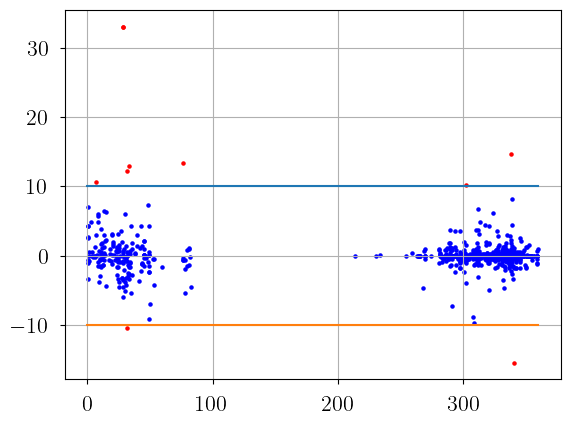

In [29]:
########################## Compare old vs new ############################################3
WISE_V23_df = pd.read_csv(os.path.join(data_dir, 'wise', 'wise_hii_V2.3_hrds.csv'), low_memory=False, skipinitialspace=True)

# Merging on different column names
dfmerged = pd.merge(WISE_V23_df, WISE_Matched_df, on='GName', how='left')
dfmerged['VLSR'] = pd.to_numeric(dfmerged['VLSR_x'], errors='coerce')

# determine where new values are "difference" km/s from old ones, or there is now a value where there wasn't before, or vise-versa
difference = 10
for i in range(len(dfmerged)):
    # Disregard multiple velocity sources and only include those with detections
    if (dfmerged['VLSR_y'][i]>-230) & (dfmerged['VLSR2'][i]!=dfmerged['VLSR2'][i]) & (dfmerged['Year'][i]>=2021):
        if (np.abs(dfmerged['VLSR'][i] - dfmerged['VLSR_y'][i]) > difference) or ((dfmerged['VLSR_x'][i]!=dfmerged['VLSR_x'][i]) or (dfmerged['VLSR_y'][i]!=dfmerged['VLSR_y'][i])):
            print(dfmerged['Name_x'][i], dfmerged['VLSR_x'][i], dfmerged['Author_x'][i], 
                  dfmerged['Name_y'][i], dfmerged['VLSR_y'][i], dfmerged['Author_y'][i], i)
            plt.scatter(dfmerged['GLong_x'][i], dfmerged['VLSR'][i] - dfmerged['VLSR_y'][i],s=5, c='r')
        else:
            plt.scatter(dfmerged['GLong_x'][i], dfmerged['VLSR'][i] - dfmerged['VLSR_y'][i],s=5, c='b')
plt.plot([0, 360], [difference, difference])
plt.plot([0, 360], [-difference, -difference])


# check - removed erroneous old positions
# TW044  8.5  Anderson et al. (2015b) G76.187+0.098;TW044 -4.81 Khan et al. (2024) 3613
# ATCA802  -72.7  Anderson et al. (2015b) ATCA802;G340.247-00.373 -57.3 Wenger et al. (2021) 7203
# ATCA810  -39.9  Anderson et al. (2015b) ATCA810;G342.438-00.061 -4.2 Wenger et al. (2021) 7324
# Different sources - fixed
#G302.504-00.749  31.0  Caswell & Haynes (1987) G302.481-00.035 -41.6 Wenger et al. (2021) 5510
# original position in between two.  Khan position better.  Removed G028.295-00.377
#G028.295-00.377  76.9  Anderson et al. (2015a) G28.287-0.364;G028.295-00.377 43.85 Khan et al. (2024) 1791
# seems fine
# G031.275+00.056  104.7  Lockman (1989) G31.279+0.063;G031.275+00.056 115.05 Khan et al. (2024) 2143
# G033.418-00.004  76.5  Lockman (1989) G33.419-0.004;G033.418-00.004 63.49 Khan et al. (2024) 2275
#FA099  11.1  Anderson et al. (2011) G7.177+0.088;FA099 0.49 Khan et al. (2024) 418
# presumably better associations now
#G338.450+00.061  -43.7000  Wenger et al. (2021) G338.450+00.061;G338.364-00.020;G338.430+00.048 -56.1 Wenger et al. (2021) 7072
# GS003; SHRDS1241  -130.200  Wenger et al. (2021) GS003;SHRDS1241;G343.353-00.068;G343.352-00.081 -23.8 Wenger et al. (2021) 7361
#   -24.5000  Wenger et al. (2021) G345.486+00.399;G345.338+01.442;G345.486+00.399 -8.3 Wenger et al. (2021) 7458

In [30]:
############### Determine if any associated sources are outside the region ##############################
distance = ((WISE_Matched_df['GLong']-WISE_Matched_df['GLong_Observed'])**2 + (WISE_Matched_df['GLat']-WISE_Matched_df['GLat_Observed'])**2)**0.5
distance[distance!=distance]=0
wh = np.where(((distance*3600.) > ((WISE_Matched_df['Radius']**2)+(WISE_Matched_df['Resolution']*60.)**2)**0.5) & np.isfinite(WISE_Matched_df['GLong_Observed']))[0]
print(WISE_Matched_df.loc[wh, ['GName', 'Name_Observed', 'GLong_Observed', 'GLat_Observed', 'Author']], distance[wh])

                GName  Name_Observed  GLong_Observed  GLat_Observed                         Author
2945  G045.118+00.144  G45.122+0.131        45.12200        0.13100             Khan et al. (2024)
2949  G045.131+00.127  G45.122+0.131        45.12200        0.13100             Khan et al. (2024)
2951  G045.133+00.132  G45.132+0.143        45.13200        0.14300             Khan et al. (2024)
4663  G206.466-16.349           S277       206.89286      -16.81918  Fich, Dahl, & Treffers (1990)
4678  G208.921-19.268           OriA       209.01100      -19.38400           Balser et al. (2011) 2945    0.013735
2949    0.010040
2951    0.010128
4663    0.635190
4678    0.146820
dtype: float64


In [31]:
################################## Numbers ##############################################
n = len(WISE_Matched_df)

n_known = np.sum(WISE_Matched_df['Catalog'] == 'K')
n_group = np.sum(WISE_Matched_df['Catalog'] == 'G')
n_observe = np.sum(WISE_Matched_df['Catalog'] == 'C')
n_no_radio = np.sum(WISE_Matched_df['Catalog'] == 'Q')
print(n, n_known+n_group+n_observe+n_no_radio, n_known, n_group, n_observe, n_no_radio)

n = len(WISE_V23_df)
n_known = np.sum(WISE_V23_df['Catalog'] == ' K')
n_group = np.sum(WISE_V23_df['Catalog'] == ' G')
n_observe = np.sum(WISE_V23_df['Catalog'] == ' C')
n_no_radio = np.sum(WISE_V23_df['Catalog'] == ' Q')
print(n, n_known+n_group+n_observe+n_no_radio, n_known, n_group, n_observe, n_no_radio)

merged_df = pd.merge(WISE_Matched_df, WISE_V23_df, on='GName', how='inner')
#print(merged_df.head(10))

diff_rows = merged_df.loc[(merged_df['Catalog_x'] != 'known') & (merged_df['Catalog_y']==' K')]
cols = ['VLSR_x', 'Author_x', 'VLSR_y', 'Author_y']
print(diff_rows[cols])

diff_rows = merged_df.loc[(merged_df['Catalog_y'] != 'known') & (merged_df['Catalog_x']==' K')]
cols = ['VLSR_x', 'Author_x', 'VLSR_y', 'Author_y']
print(diff_rows[cols])

8589 8589 2531 730 3254 2074
8416 0 0 0 0 0
Empty DataFrame
Columns: [VLSR_x, Author_x, VLSR_y, Author_y]
Index: []
Empty DataFrame
Columns: [VLSR_x, Author_x, VLSR_y, Author_y]
Index: []


# Create WISE Catalog Database

In [63]:
# Fix datatypes
WISE_Matched_df["Group"] = WISE_Matched_df["Group"].astype(str)

In [64]:
WISE_Matched_df0 = WISE_Matched_df.copy()
db_file = os.path.join(data_dir, "db", f"WISE_HII_V{wise_master_version}.db")
conn = sqlite3.connect(db_file)

# Convert object columns to strings (this will handle most non-numeric data)
for col in WISE_Matched_df0.select_dtypes(include='object').columns:
    WISE_Matched_df0[col] = WISE_Matched_df0[col].astype(str)
    
# Write the DataFrame to the SQLite database as a new table
table_name = 'Catalog'
WISE_Matched_df0.to_sql(table_name, conn, if_exists='replace', index=False)

# Commit and close the connection to the database
conn.commit()
conn.close()

# Save the DataFrame to a pkl and csv file too
WISE_Matched_df.to_pickle(os.path.join(data_dir, "wise", f"WISE_HII_V{wise_master_version}.pkl"))
WISE_Matched_df.to_csv(os.path.join(data_dir, "wise", f"WISE_HII_V{wise_master_version}.csv"), index=False)

In [65]:
WISE_Matched_df.dtypes

Catalog                         object
GLong                          float64
GLat                           float64
Radius                         float64
Comments                        object
Group_Flag                       int64
Group                           object
Name                            object
Alias                           object
Simbad_comments                 object
VGPSExclude                      int64
MagpisExclude                    int64
Parallax_Name                   object
Magpis                           int64
NVSS                             int64
Cornish                          int64
Yusef20cmGC                      int64
LangRadio                        int64
LangPaschen                      int64
THOR                             int64
SMGPS                            int64
MeerKATGC                        int64
GName                           object
RA (J2000)                     float64
Dec (J2000)                    float64
Name_Split               

In [75]:
WISE_Matched_df["Resolution"].unique()

array([3.  ,  nan, 0.42, 2.  , 2.65, 1.3 , 9.  , 1.1 , 6.  , 2.5 , 4.  ,
       5.  , 0.8 , 0.5 ])

##### WISE_Matched_df["KDAR"].unique()